<h1>Reconocimiento de imagen pa loh profes</h1>

<h2>Packages & libs</h2>

In [1]:
import sys
!{sys.executable} -m pip install opencv-python

In [2]:
!tesseract -v

tesseract 4.0.0-beta.1
 leptonica-1.75.3
  libgif 5.1.4 : libjpeg 8d (libjpeg-turbo 1.5.2) : libpng 1.6.34 : libtiff 4.0.9 : zlib 1.2.11 : libwebp 0.6.1 : libopenjp2 2.3.0

 Found AVX2
 Found AVX
 Found SSE


In [3]:
!{sys.executable} -m pip install pytesseract

  Running setup.py bdist_wheel for pytesseract ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/81/20/7e/1dd0daad1575d5260916bb1e9781246430647adaef4b3ca3b3
Successfully built pytesseract


In [30]:
!{sys.executable} -m pip install easyocr

    100% |████████████████████████████████| 63.2MB 113kB/s eta 0:00:01   14% |████▋                           | 9.0MB 36.7MB/s eta 0:00:02    21% |███████                         | 13.8MB 34.2MB/s eta 0:00:02    29% |█████████▍                      | 18.6MB 18.5MB/s eta 0:00:03    94% |██████████████████████████████▎ | 59.8MB 42.5MB/s eta 0:00:01    97% |███████████████████████████████▎| 61.7MB 42.4MB/s eta 0:00:01
    100% |████████████████████████████████| 17.4MB 5.9MB/s eta 0:00:01   15% |█████                           | 2.7MB 32.7MB/s eta 0:00:01    33% |██████████▋                     | 5.8MB 29.0MB/s eta 0:00:01    50% |████████████████▎               | 8.8MB 27.0MB/s eta 0:00:01    60% |███████████████████▍            | 10.5MB 36.3MB/s eta 0:00:01
    100% |████████████████████████████████| 804.1MB 1.6kB/s eta 0:00:01 0% |                                | 1.4MB 27.0MB/s eta 0:00:30    0% |▎                               | 6.9MB 28.0MB/s eta 0:00:29    1% |▌                     

In [4]:
!{sys.executable} -m pip install deskew

In [17]:
!{sys.executable} -m pip install scipy

In [115]:
import os

In [5]:
import cv2 as cv

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pytesseract


In [31]:
from easyocr import Reader
import argparse

In [20]:
from skimage import io
from skimage import data
from skimage.color import rgb2gray
from skimage.transform import rotate
from skimage.filters import threshold_otsu, threshold_local, try_all_threshold

In [8]:
from deskew import determine_skew

<h2>Image for testing shadow behaviour, binarization of image</h2>

<p>The idea is to choose from here the best approach for our use case, for that we are testing:
    
   - Scikit-image (skimage):
        - Isodata
        - Li
        - Mean
        - Minimun
        - Otsu
        - Triangle
        - Yen
   
   - Open-CV:
       - Global Thresholding
       - Adaptive Mean Thresholding
       - Adaptive Gaussian Thresholding
 </p>

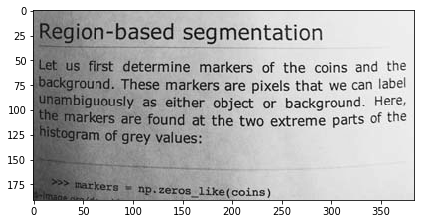

In [16]:
#This is the test for the image, provided by skimage
img = data.page()
#img = io.imread('imgtest1.jpeg')
#img = io.imread('output.png')
io.imshow(img)
plt.show()

<h3>Testing scikit-image (B1)<h3>

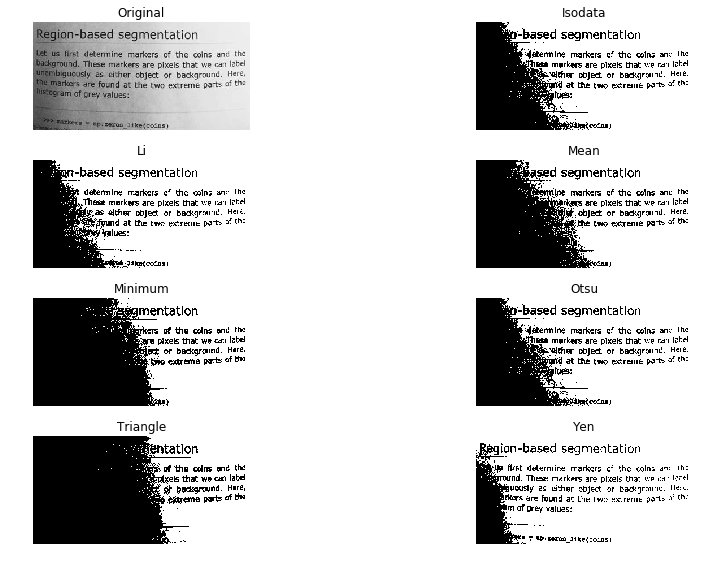

In [10]:
fig, ax = try_all_threshold(img, figsize=(15, 8), verbose=False)

/opt/conda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:80: UserWarning:

Float image out of standard range; displaying image with stretched contrast.



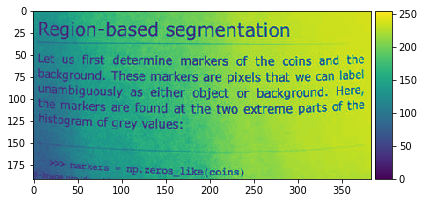

In [108]:
io.imshow(threshold_local(img, 1), vmin=0, vmax=255)

<h3>Testing with open CV (B2)<h3>

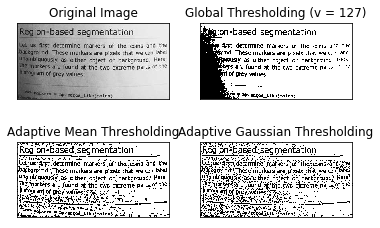

In [11]:
#img = cv.imread('imgtest1.jpeg', 0)
#img = cv.medianBlur(img,5)
ret,th1 = cv.threshold(img,127,255,cv.THRESH_BINARY)
th2 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_MEAN_C,\
            cv.THRESH_BINARY,11,2)
th3 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv.THRESH_BINARY,11,2)
titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img, th1, th2, th3]
for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

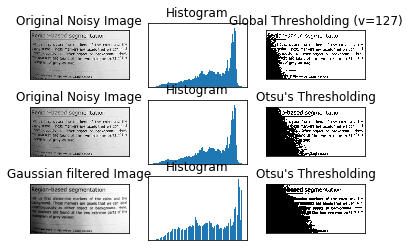

In [12]:
# global thresholding
ret1,th1 = cv.threshold(img,127,255,cv.THRESH_BINARY)
# Otsu's thresholding
ret2,th2 = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
# Otsu's thresholding after Gaussian filtering
blur = cv.GaussianBlur(img,(5,5),0)
ret3,th3 = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
# plot all the images and their histograms
images = [img, 0, th1,
          img, 0, th2,
          blur, 0, th3]
titles = ['Original Noisy Image','Histogram','Global Thresholding (v=127)',
          'Original Noisy Image','Histogram',"Otsu's Thresholding",
          'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]
for i in range(3):
    plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
    plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.show()

<h2>Removing skewness from the images</h2>

<h3>testing in an skewed image</h3>

In [13]:
skImg = io.imread('skewTest.jpeg')

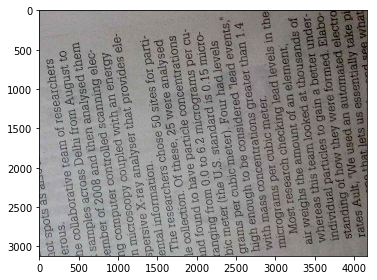

In [14]:
io.imshow(skImg)
plt.show()

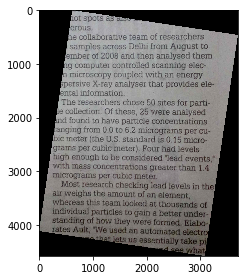

In [15]:
grayscale = rgb2gray(skImg)
angle = determine_skew(grayscale)
rotated = rotate(skImg, angle, resize=True) * 255
#toSave
io.imsave('output.png', rotated.astype(np.uint8))

io.imshow(rotated.astype(np.uint8))
plt.show()

<h2>Optical Caracter Recognition<h2>

<p>The following step is a comparison between Tesseract-OCR and Easy-OCR to see the most precise OCR</p>

<h3>OCR input image</h3>

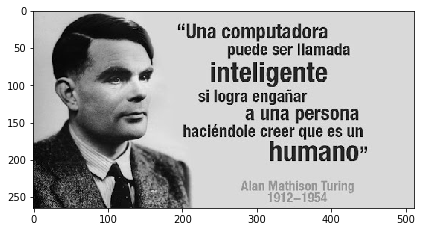

In [23]:
imgOCR = io.imread('turingOCR.jpg')

io.imshow(imgOCR)

plt.show()

<h3>Tesseract-OCR</h3>

In [25]:
text = pytesseract.image_to_string(imgOCR, lang='spa')

In [26]:
print(text)

   
 

“Una computadora
puede ser llamada

inteligente
si logra engañar
a una persona
haciéndole creer que es un

humano»



<h3>Easy-OCR</h3>

In [42]:
#This is to load the model, needs to be run only once per instance
reader = Reader(['es','en'], gpu = False)

Using CPU. Note: This module is much faster with a GPU.


In [56]:
#This will give the OCR result as an output for the matrix
reader.readtext(imgOCR, detail = 2)

[([[189, 11], [403, 11], [403, 48], [189, 48]],
  "'Una computadora",
  0.83982274228813036),
 ([[257, 38], [430, 38], [430, 66], [257, 66]],
  'puede ser Ilamada',
  0.90597735286441528),
 ([[230, 62], [402, 62], [402, 110], [230, 110]],
  'inteligente',
  0.99999209252971921),
 ([[218, 100], [373, 100], [373, 132], [218, 132]],
  'si logra engañar',
  0.93822412725831383),
 ([[284, 126], [444, 126], [444, 156], [284, 156]],
  'a una persona',
  0.76362602494729004),
 ([[198, 147], [446, 147], [446, 176], [198, 176]],
  'haciéndole creer que es un',
  0.80092354095252905),
 ([[313, 171], [457, 171], [457, 209], [313, 209]],
  'humano"',
  0.99661906774675224),
 ([[276, 222], [436, 222], [436, 248], [276, 248]],
  'Alan Mathison Turing',
  0.9872317911563856),
 ([[313, 241], [397, 241], [397, 261], [313, 261]],
  '1912-1954',
  0.96200522934144883)]

In [51]:
#This is the lowest level of detail
reader.readtext(imgOCR, detail = 0)

["'Una computadora",
 'puede ser Ilamada',
 'inteligente',
 'si logra engañar',
 'a una persona',
 'haciéndole creer que es un',
 'humano"',
 'Alan Mathison Turing',
 '1912-1954']

<h2>Testing for images</h2>

<p>this is a test focused on extracting text from sample images, and generating a CSV for a more detailed analysis</p>

In [125]:
def readImages(imgPath):
    try:
        img = io.imread(imgPath)
        return img
    except:
        print('Error in reading image')

In [126]:
def ocrImage(image, lang):
    try:
        text = pytesseract.image_to_string(image, lang)
        return text
    except:
        print('Error in Tesseract')

In [127]:
 def deskewImages(image):
    try:
        grayscale = rgb2gray(image)
        angle = determine_skew(grayscale)
        rotated = rotate(image, angle, resize=True) * 255
        #toSave
        img = rotated.astype(np.uint8)
        return img
    except:
        print('Error in deskewing image')

<h4>Orchestator</h4>

In [ ]:
directory = 'Resources/Images/'

df = pd.DataFrame(columns = ['File', 'Text'])

i = 1
while i <= 51:
    try:
        
        imgName = 'Img' + str(i) + '.jpeg'
        img = io.imread(directory + imgName)
        img = deskewImages(img)   
        imgText = ocrImage(img, 'spa')
        
        print(imgName, imgText)
        df.append({'File' : imgName, 'Text' : imgText}, ignore_index = True)
        
        i = i + 1
        
    except:
        print('Error in orchestator')
        df.append({'File' : imgName, 'Text' : 'Error in Orchestator'}, ignore_index = True)
        i = i + 1

